# Carbon sequestration and temperature-dependent CO2-C emission kinetics in cranberry soils
*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi and Bertrand Normand*

In [21]:
print(Sys.Date())

[1] "2020-04-29"


## Objective

This notebook generate the result of co2 data analysis. Data set contains a collection of soil caracteristics, measured co2 emission collected from incubation study. Soil samples was collected from two cranberry fied stand of eastern canada. Incubation study was carried out at Agriculture and Agri-food Canada(sainte-foy, quebec,qc) from February to Mai 2019. The objectif of this study was to measure CO2 emission rate across cranberry soil profiles as related to change in soil temperature in cranberry soils of eastern Canada. 

## Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation(Ex: [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (ex: [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). We also need [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting a nonlinear mixed-effects model and [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) package for latent class analysis.

In [22]:
library("tidyverse") # imports ggplot2, dplyr, etc.
library(nlme)
library('e1071')

## Import data
We load two data `data_pot` and `data_co2` involved in our anylisis. `data_pot` contained details about sites sampling, soil sampling(soil depth, weight, water content and bulk density), laboratory incubation temperature while `data_co2` contained details about laboratory incubation time, co2 emission and jar masson details.

In [23]:
data_pots <- read_csv('data/pots.csv')
data_co2 <- read_csv('data/co2.csv')
#data_soil <- read_csv('data/data_soil.csv')

data_co2 <- data_co2 %>%
  left_join(data_pots, by = "ID pot")

Parsed with column specification:
cols(
  `ID pot` = col_double(),
  Sites = col_character(),
  `Total carbon (ppm)` = col_double(),
  `Depth (cm)` = col_double(),
  Block = col_double(),
  `Temperature (°C)` = col_double(),
  `Pot weight (g)` = col_double(),
  `Soil weight (g)` = col_double(),
  `Water volume (ml)` = col_double(),
  `Water content (%)` = col_double(),
  `Bulk density (g/mL)` = col_double()
)
Parsed with column specification:
cols(
  `ID pot` = col_double(),
  `Time (days)` = col_double(),
  `Initial CO2 (ppm)` = col_double(),
  `Final CO2 (ppm)` = col_double(),
  `Time final (h)` = col_double()
)


## Some calculations 

Arrhenius equation:

$$k = A e^{\frac{-E_{a}}{R T}}$$

In [24]:
arrhenius_f <- function(A, Ea, T, R = 8.3144621) {
    k <- A * exp(-Ea / (R * T))
    return(k)
}

### Molar volume

Several variables have been added to our data in order to proceed for analysis. The added variables are the following: `Temperature (Kelvin)`, `Molar Volume (L/mol)`, `Headspace Volume (mL)`, `Dry soil weight (g)`, `CO2 emission (ug/h/g)`, `CO2 emission (mg/kg)`, `decomposition rate K`, `lnK`and `1/T(T = Temperature(Kelvin)`

In [25]:
container_volume <- 250 # mL
gas_constant <- 8.31446 # unit
atm_pressure_n <- 101.325

data_co2 <- data_co2 %>%
  mutate(`Temperature (K)` = `Temperature (°C)` + 273,
         `Molar Volume (L/mol)` = gas_constant * `Temperature (K)` / atm_pressure_n,
         `Headspace Volume (mL)` = container_volume - (`Soil weight (g)` / `Bulk density (g/mL)`), # 250 mL is the volume of the container
         `Dry soil weight (g)` = `Soil weight (g)` - (`Soil weight (g)` * `Water content (%)` / 100),
         `CO2 emission (ug/h/g)` = (`Final CO2 (ppm)` - `Initial CO2 (ppm)`) * 0.000001 * 44000000 /
                                   `Molar Volume (L/mol)` * (`Headspace Volume (mL)` / 1000) * (12 / 44) /
                                   `Time final (h)` / `Dry soil weight (g)`,
         `CO2 emission (mg/kg)` = `CO2 emission (ug/h/g)` * 24 * `Time (days)`,
         K = log(`Total carbon (ppm)` / (`Total carbon (ppm)` - `CO2 emission (mg/kg)`)) / `Time (days)`,
         lnK = log(K),
         `1/T` = 1 / `Temperature (K)`)

Warning message in log(K):
"production de NaN"

### Computing K median in order to compute Q10 value accross soil depth

In [26]:
K_median <- aggregate(K ~ `Depth (cm)` + `Temperature (°C)`, data = data_co2, FUN = median)

K_median_01 <- K_median %>%
  pivot_wider(names_from = `Temperature (°C)`, values_from = K)

K_median_01$Q_20_10 <- K_median_01$`20` / K_median_01$`10`
K_median_01$Q_30_20 <- K_median_01$`30` / K_median_01$`20`
K_median_01

Depth (cm),10,20,30,Q_20_10,Q_30_20
10,5.423944e-05,1.243877e-04,2.167872e-04,2.293308,1.742835
20,1.432778e-05,3.899537e-05,7.573282e-05,2.721661,1.942098
30,7.804890e-07,1.691689e-05,5.341681e-05,21.674729,3.157603


### Fit of Arrhenius equation

In [27]:
models_co2 <- data_co2 %>%
  group_by(`Depth (cm)`) %>%
  summarise(linmod = list(lm(lnK ~ `1/T`)))

In [28]:
linmod_coef <- list()
for (i in seq_along(models_co2$linmod)) linmod_coef[[i]] <- models_co2$linmod[[i]]$coefficients
linmod_coef <- do.call(rbind.data.frame, linmod_coef)
names(linmod_coef) <- c("Intercept", "Slope")
linmod_coef <- bind_cols(unique(data_co2["Depth (cm)"]), linmod_coef)

Warning message:
"Removed 191 rows containing missing values (geom_point)."Warning message:
"Removed 191 rows containing missing values (geom_point)."

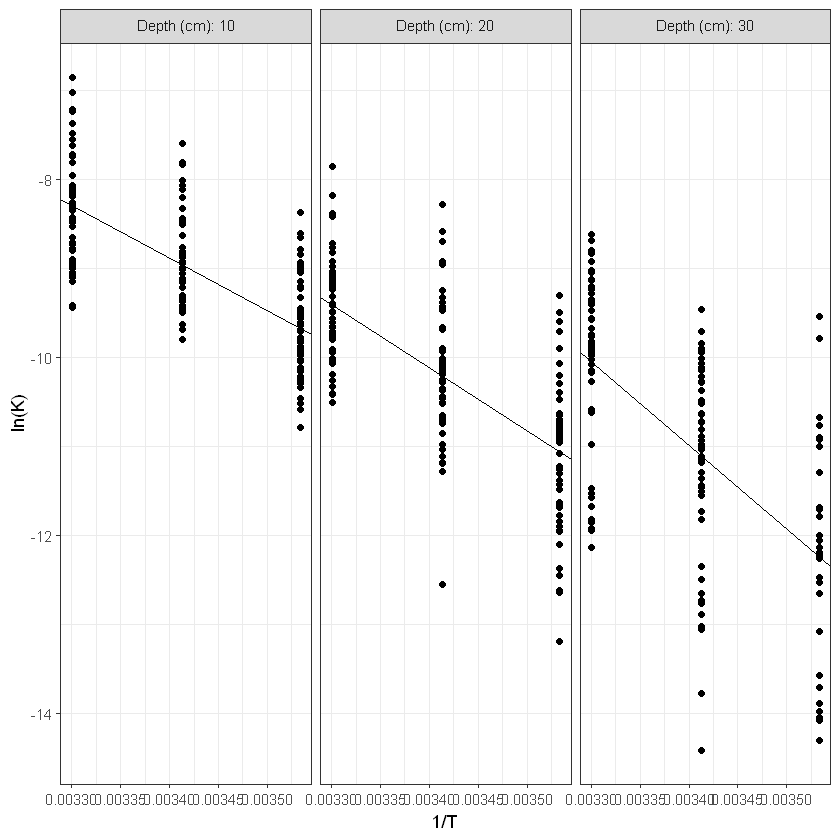

In [33]:
data_co2 %>%
  ggplot(aes(x = `1/T`, y = lnK)) +
  facet_grid(~`Depth (cm)`, labeller = label_bquote(cols = "Depth (cm):"~.(`Depth (cm)`))) +
  geom_abline(data = linmod_coef, aes(intercept = Intercept, slope = Slope)) +
  geom_point() +
  labs(y = "ln(K)") +
  theme_bw()
ggsave("figures/Arrhénius équation.png", width = 8, height = 5, dpi = 150)# export plot high resolution

Warning message:
"Removed 191 rows containing non-finite values (stat_boxplot)."

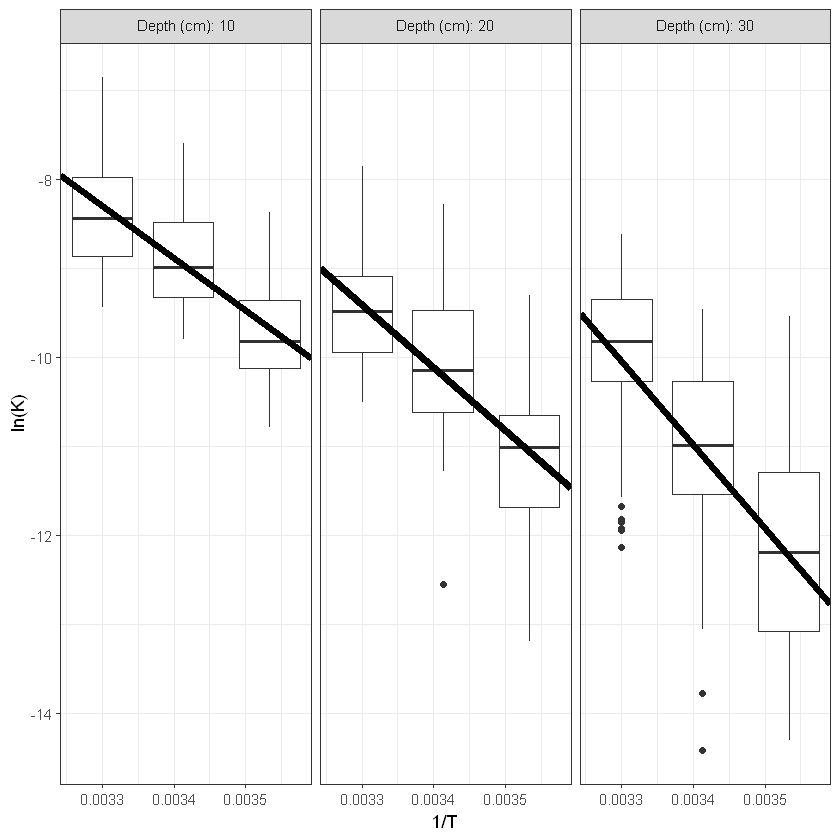

In [30]:
data_co2 %>%
  ggplot(aes(x = `1/T`, y = lnK)) +
  facet_grid(~`Depth (cm)`, labeller = label_bquote(cols = "Depth (cm):"~.(`Depth (cm)`))) +
  geom_boxplot(aes(group = factor(`1/T`))) +
  geom_abline(data = linmod_coef, aes(intercept = Intercept, slope = Slope), lwd = 2) +
  labs(y = "ln(K)") +
  theme_bw()

### Activation Energy computation

In [34]:
modlin_depth10 <- lm(lnK ~ `1/T`, data_co2, subset = (`Depth (cm)` == 10))
modlin_depth20 <- lm(lnK ~ `1/T`, data_co2, subset = (`Depth (cm)` == 20))
modlin_depth30 <- lm(lnK ~ `1/T`, data_co2, subset = (`Depth (cm)` == 30))

slope_depth10 <- coef(modlin_depth10)[2]
slope_depth20 <- coef(modlin_depth20)[2]
slope_depth30 <- coef(modlin_depth30)[2]

R = 8.3144621 / 1000 # Kj/mol/K 
Ea_depth10 <- - slope_depth10 * R
names(Ea_depth10) <- "Ea_10"
Ea_depth10
Ea_depth20 <- - slope_depth20 * R
names(Ea_depth20) <- "Ea_20"
Ea_depth20
Ea_depth30 <- - slope_depth30 * R
names(Ea_depth30) <- "Ea_30"
Ea_depth30

Ea_10 
48.88879

Ea_20 
58.81571

Ea_30 
77.81623

In [37]:
summary(modlin_depth10)$adj.r.squared
summary(modlin_depth10)$coefficients

[1] 0.4753383

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),11.10778,1.657889,6.699955,3.371670e-10
`1/T`,-5879.96968,485.195538,-12.118763,2.139041e-24


In [38]:
summary(modlin_depth20)$adj.r.squared
summary(modlin_depth20)$coefficients

[1] 0.4447818

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),13.93185,2.139542,6.511606,9.536927e-10
`1/T`,-7073.90408,626.296695,-11.294813,4.990664e-22


In [39]:
summary(modlin_depth30)$adj.r.squared
summary(modlin_depth30)$coefficients

[1] 0.3564831

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),20.83335,3.650929,5.706314,7.082031e-08
`1/T`,-9359.14146,1075.091066,-8.705441,1.024174e-14


## Some custom functions.
Pseudo R-square allows to measure how well variables of our model explain co2 emission rate

In [12]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  library(e1071)
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## Data Exploration

### Boxplot

<ScaleContinuousPosition>
 Range:  
 Limits:    0 --    1

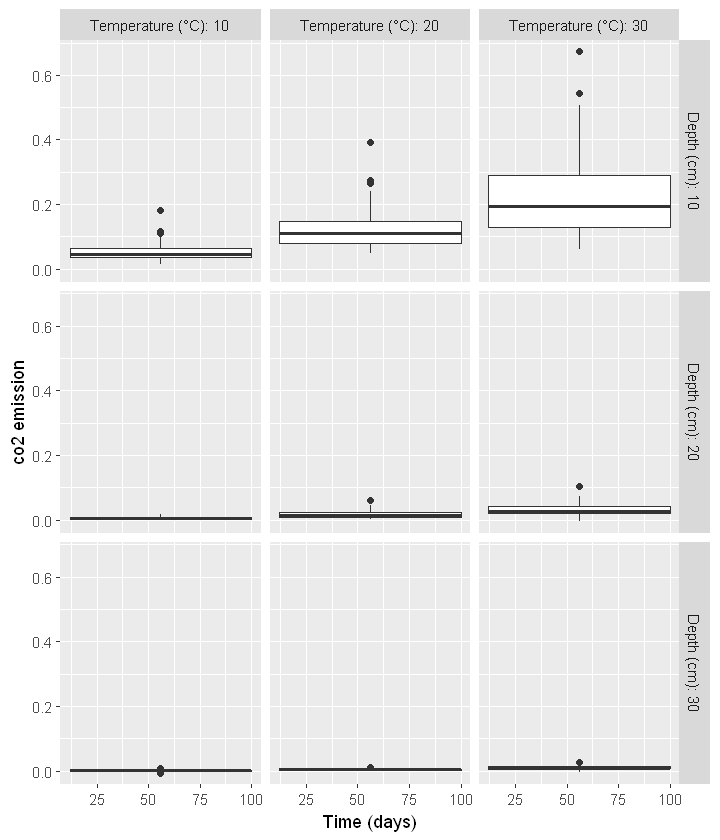

In [13]:
options(repr.plot.width = 6, repr.plot.height = 7)
pg <- ggplot(data=data_co2, aes(x = `Time (days)`,y = `CO2 emission (ug/h/g)` , group = `Temperature (°C)`)) +# geom_point(color= "black", size=2) +
 facet_grid(`Depth (cm)` ~ `Temperature (°C)`,labeller = label_both)+  #scales = "free", 
 #geom_jitter(width=0.25)+ 
        geom_boxplot(alpha=0.5)+
  xlab("Time (days)") + ylab("co2 emission")
pg +geom_boxplot() #boxplot(color="#993399", aes(group= PROFONDEUR)) +
scale_y_log10()

## linear regression

In [14]:
data_co2 <- data_co2 %>%
  rename(Co2 = `CO2 emission (ug/h/g)`,
         Time = `Time (days)`,
         Depth = `Depth (cm)`,
         Temperature = `Temperature (°C)`,
         Id = `ID pot`)%>%
  drop_na() %>%
  droplevels()

co2_lm <- lm((log10(Co2)) ~ Time + Depth + Temperature,
                     data = data_co2) 

In [15]:
summary(co2_lm)


Call:
lm(formula = (log10(Co2)) ~ Time + Depth + Temperature, data = data_co2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.34296 -0.15630  0.03048  0.17729  0.80750 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.8851447  0.0468129 -18.908   <2e-16 ***
Time        -0.0031918  0.0003649  -8.748   <2e-16 ***
Depth       -0.0741976  0.0015185 -48.861   <2e-16 ***
Temperature  0.0361799  0.0015260  23.710   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2605 on 453 degrees of freedom
Multiple R-squared:  0.8623,	Adjusted R-squared:  0.8614 
F-statistic: 945.7 on 3 and 453 DF,  p-value: < 2.2e-16


### p-value

In [16]:
summary(co2_lm)$coefficients[,4]

(Intercept)          Time         Depth   Temperature 
 3.323913e-59  4.306297e-17 1.063815e-182  2.131218e-81

### CO2 emission in cranberry soils in three-layer positions (0-10 cm, 10-20 cm, 20-30 cm) and at three temperatures (10, 20 and 30oC).
Here, we use our model `co2_lm` to predict co2 emission trend. In order to do that, we create a new data called `Data_exp` following predicted Co2 column. The trend line was drawn with `data_exp`

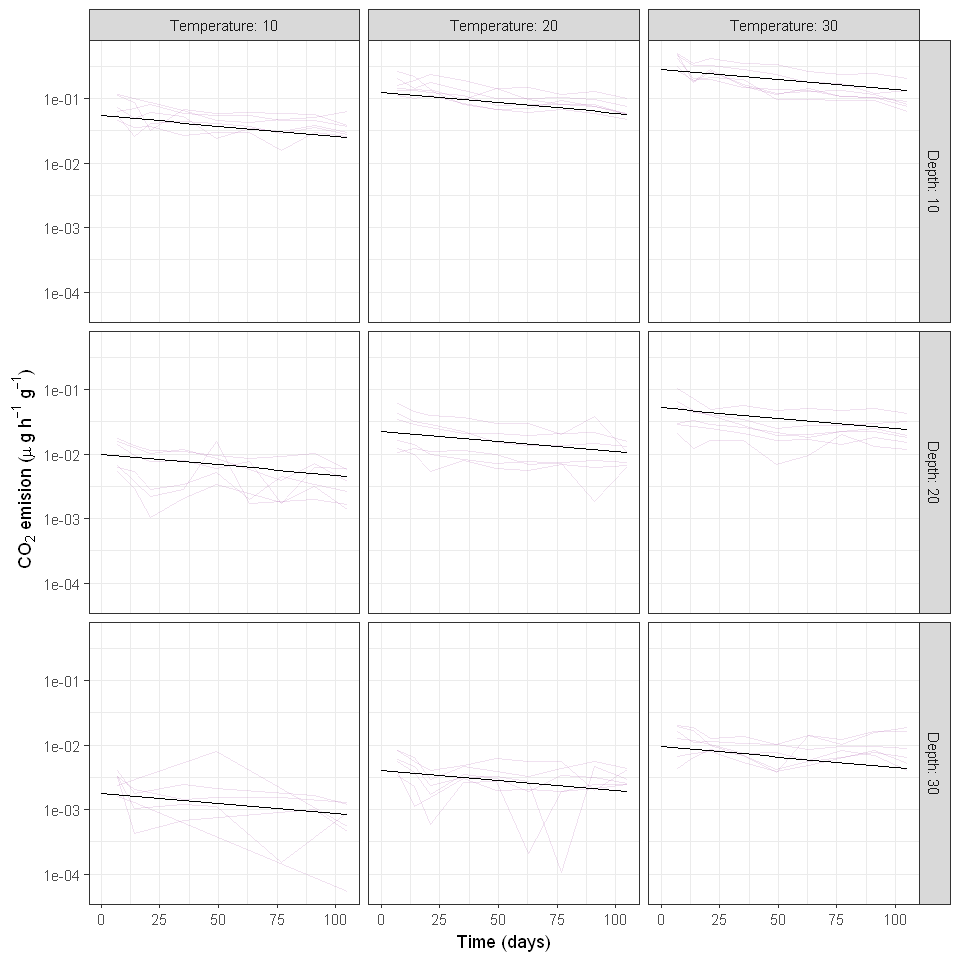

In [64]:
Data_exp <- expand.grid(Time = seq(0, 105, 5), Depth = c(10, 20, 30), Temperature = c(10, 20, 30))
Data_exp$Co2 <- 10^predict(co2_lm, newdata = Data_exp, level=0)

options(repr.plot.width = 8, repr.plot.height = 8)
theme_set(theme_bw())
pl <- ggplot(data = data_co2, aes(x = Time, y = Co2)) +
 facet_grid(Depth ~ Temperature, labeller = label_both) +
  xlab("Time (days)") + ylab(bquote(~CO[2]~ 'emision ('*mu~'g'~ h^-1~g^-1*')'))
pl + geom_line(color="#993399", aes(group= Id), alpha=0.15) +
  geom_line(data = Data_exp) +
  scale_y_log10()
ggsave("figures/CO2 emission.png", width = 5, height = 5, dpi = 150)# export plot high resolution

### Pseudo r-square

In [65]:
pseudoR2(y = log10(data_co2$Co2),
         y_hat = predict(co2_lm))

[1] 0.8623199

### Normality test

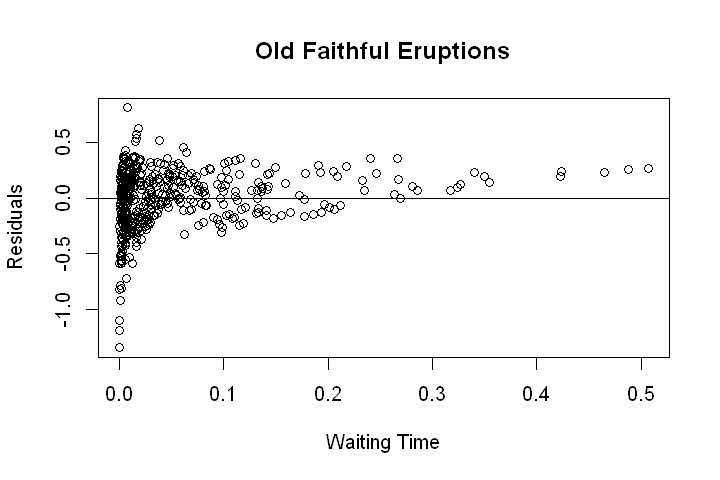

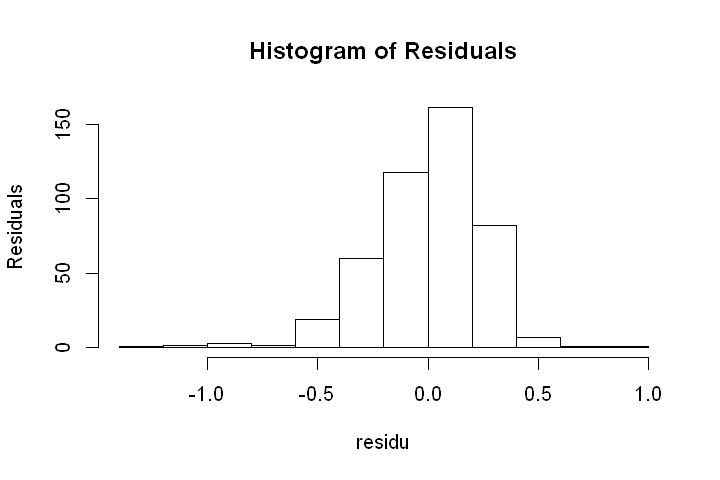

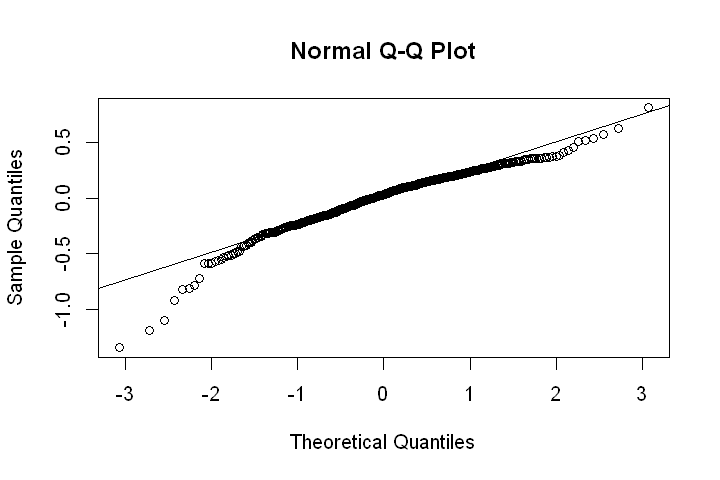

In [66]:
options(repr.plot.width=6, repr.plot.height=4)
residu <- resid(co2_lm)
plot(data_co2$Co2, residu, 
     ylab="Residuals", xlab="Waiting Time", 
    main="Old Faithful Eruptions") 
 abline(0, 0)  

#Histogram of Residuals
hist(residu, main="Histogram of Residuals",
 ylab="Residuals")

#Q-Q Plot
qqnorm(residu)
qqline(residu)

## Relationship between predicted and observed CO2 emission

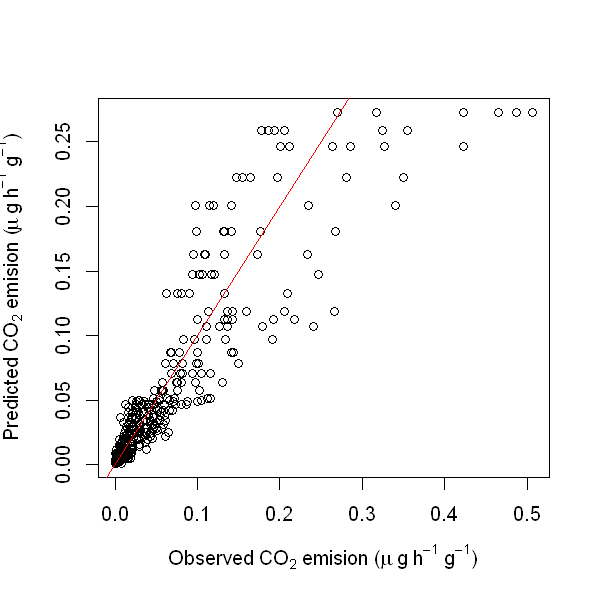

In [67]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot <- plot(x = data_co2$Co2, y = 10**predict(co2_lm), xlab = (bquote('Observed'~CO[2]~ 'emision ('*mu~'g' ~ h^-1~g^-1*')')),
             ylab = (bquote('Predicted'~CO[2]~ 'emision ('*mu~'g' ~ h^-1~g^-1*')'))) 
abline(0,1, col = "red")